In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37357 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37357/status,
Dashboard: http://127.0.0.1:37357/status,Workers: 28
Total threads: 56,Total memory: 1.48 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35399,Workers: 28
Dashboard: http://127.0.0.1:37357/status,Total threads: 56
Started: Just now,Total memory: 1.48 TiB
Comm: tcp://127.0.0.1:41873,Total threads: 2
Dashboard: http://127.0.0.1:46077/status,Memory: 53.95 GiB
Nanny: tcp://127.0.0.1:38477,


In [4]:
epoch_key = 'Jaq', 3, 12

In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

03-Nov-21 20:38:11 Loading position info...
03-Nov-21 20:39:05 Loading multiunit...
03-Nov-21 20:39:28 Loading spikes...
03-Nov-21 20:40:41 Finding ripple times...


In [6]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [7]:
from replay_identification import ReplayDetector

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

03-Nov-21 20:41:24 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty

In [8]:
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING


replay_detector.fit(
    is_ripple=data['is_ripple'],
    is_training=data['position_info'].nose_vel > 4,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
)

03-Nov-21 20:41:24 Fitting speed model...
03-Nov-21 20:41:26 Fitting spiking model...
03-Nov-21 20:44:32 Fitting replay movement state transition...
03-Nov-21 20:44:32 Fitting replay state transition...


ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty=0.5)

In [9]:
detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True)

detector_results

03-Nov-21 20:44:32 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

03-Nov-21 20:45:55 Finding causal non-local probability and position...
03-Nov-21 20:46:03 Finding acausal non-local probability and position...


<xarray.Dataset>
Dimensions:                (time: 448713, state: 2, position: 161)
Coordinates:
  * time                   (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position               (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 0.0 0.0 ... 4.527e-09
    likelihood             (time, state, position) float64 1.0 1.0 ... 1.0 1.0
    acausal_posterior      (time, state, position) float64 0.0 0.0 ... 4.527e-09
    non_local_probability  (time) float64 0.0 1.701e-07 ... 0.9769 0.9033

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]})
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    max_consensus = np.ceil(data['ripple_consensus_trace'].values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = data['ripple_consensus_trace'].loc[start_time:end_time]
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((0, max_consensus))
    axes[0].set_yticks((0, max_consensus))
    axes[0].set_ylabel("Ripple\nPower")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).non_local_probability >= 0.8,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

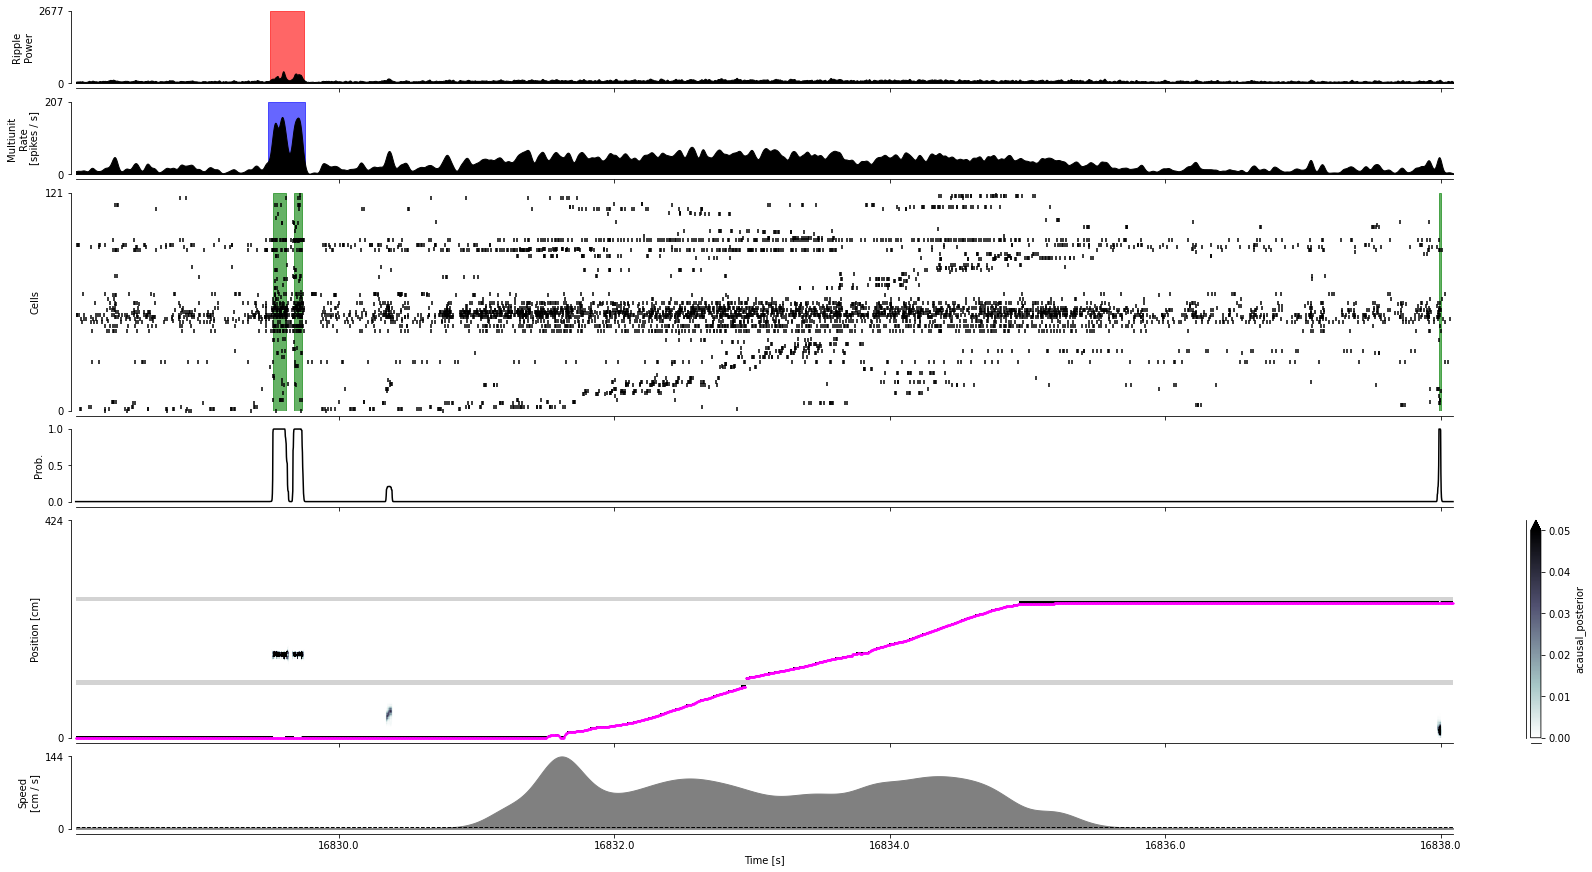

In [11]:
time_slice = slice(230_000, 235_000)
plot_detector(time_slice, data, replay_detector, detector_results, figsize=(22, 12.0))

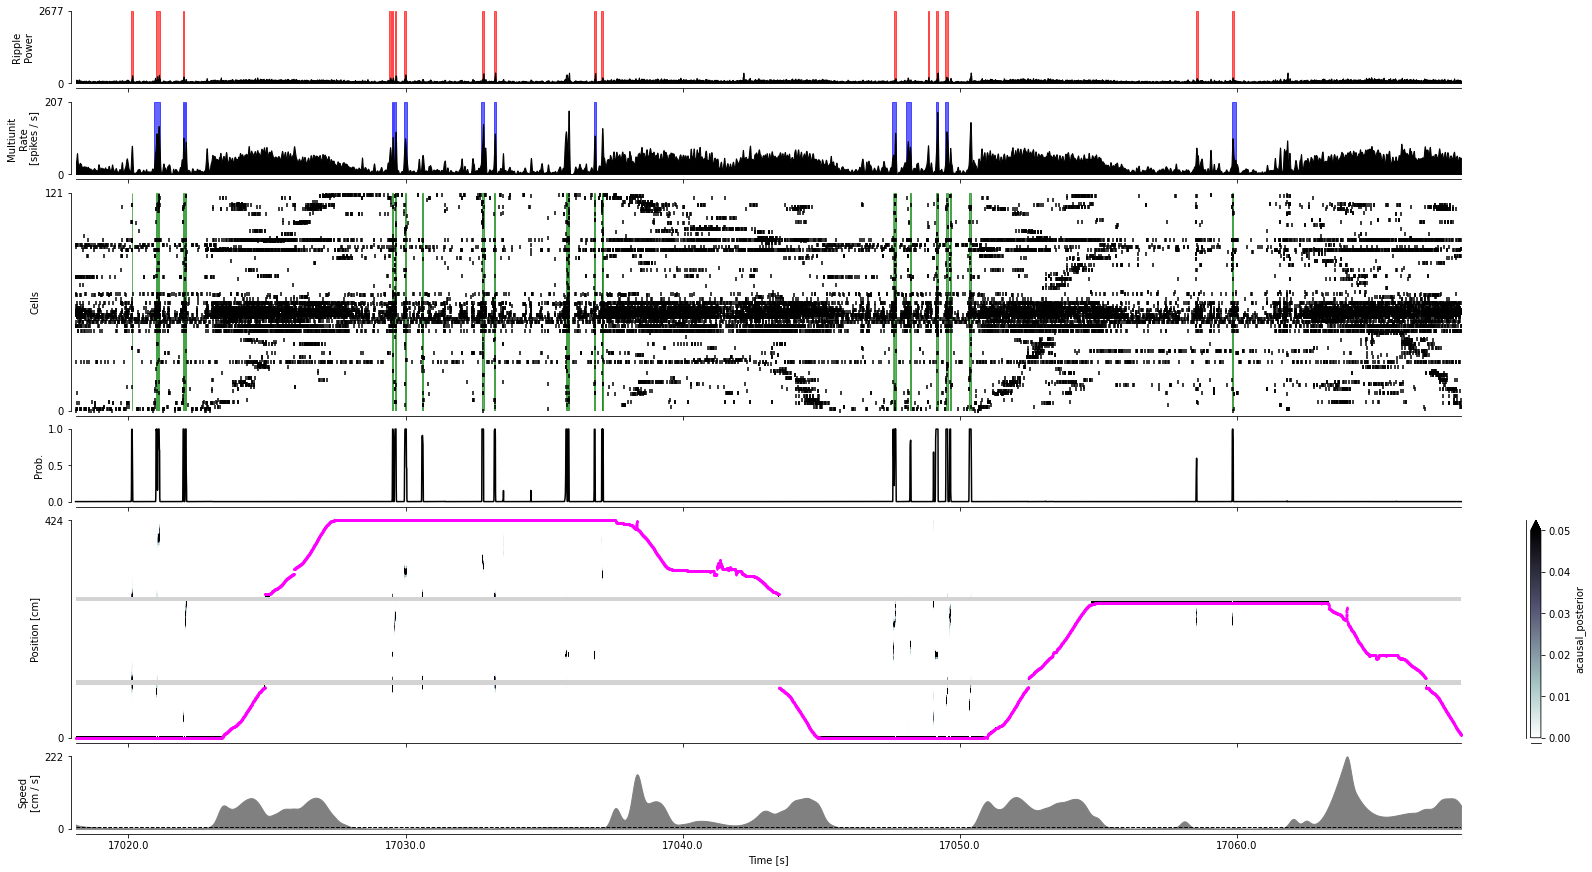

In [12]:
time_slice = slice(325_000, 350_000)

plot_detector(time_slice, data, replay_detector, detector_results, figsize=(22, 12.0))

In [13]:
detector_parameters_2D = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 16.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

replay_detector_2D = ReplayDetector(**detector_parameters_2D)

replay_detector_2D.fit(
    is_ripple=data['is_ripple'],
    is_training=data['position_info'].nose_vel > 4,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].loc[:, ['nose_x', 'nose_y']],
    spikes=data['spikes'],
)

03-Nov-21 20:46:53 Fitting speed model...
03-Nov-21 20:46:54 Fitting spiking model...
03-Nov-21 20:50:01 Fitting replay movement state transition...
03-Nov-21 20:50:02 Fitting replay state transition...


ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=16.0,
               spike_model_penalty=0.5)

In [20]:
place_conditional_intensity = (
            replay_detector_2D._spiking_likelihood
            .keywords['place_conditional_intensity']).squeeze()

In [24]:
detector_results_2D = replay_detector_2D.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].loc[:, ['nose_x', 'nose_y']],
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True)

detector_results_2D

03-Nov-21 20:54:15 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

03-Nov-21 21:12:45 Finding causal non-local probability and position...
03-Nov-21 21:17:58 Finding acausal non-local probability and position...


<xarray.Dataset>
Dimensions:                (time: 448713, state: 2, position: 161)
Coordinates:
  * time                   (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position               (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 0.0 0.0 ... 4.527e-09
    likelihood             (time, state, position) float64 1.0 1.0 ... 1.0 1.0
    acausal_posterior      (time, state, position) float64 0.0 0.0 ... 4.527e-09
    non_local_probability  (time) float64 0.0 1.701e-07 ... 0.9769 0.9033

In [27]:
detector_results_2D

<xarray.Dataset>
Dimensions:                (time: 448713, state: 2, x_position: 48, y_position: 43)
Coordinates:
  * time                   (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * x_position             (x_position) float64 1.248 3.745 ... 116.1 118.6
  * y_position             (y_position) float64 1.248 3.745 ... 103.6 106.1
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, x_position, y_position) float64 0.0 ...
    likelihood             (time, state, x_position, y_position) float64 0.0 ...
    acausal_posterior      (time, state, x_position, y_position) float64 0.0 ...
    non_local_probability  (time) float64 0.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.968

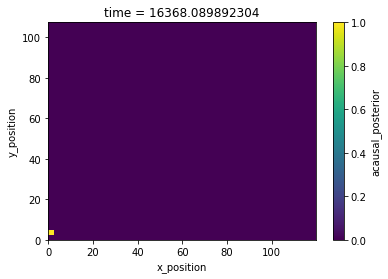

In [26]:
detector_results_2D.isel(time=0).acausal_posterior.sum('state').plot(x='x_position', y='y_position')

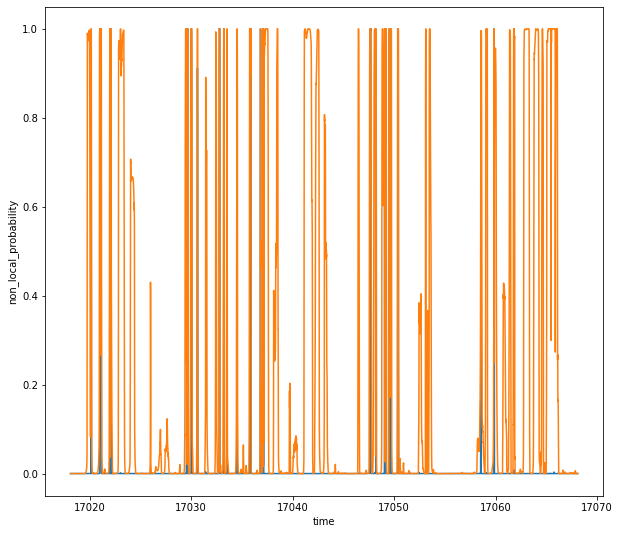

In [32]:
fig, ax = plt.subplots(figsize=(10, 9))
detector_results.isel(time=time_slice).non_local_probability.plot(x='time', ax=ax)
detector_results_2D.isel(time=time_slice).non_local_probability.plot(x='time', ax=ax)

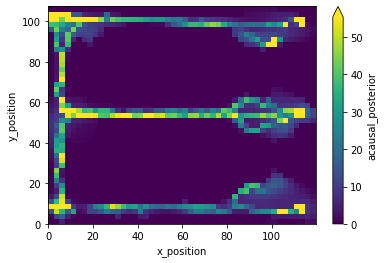

In [36]:
detector_results_2D.isel(time=time_slice).acausal_posterior.sum(['state', 'time']).plot(x='x_position', y='y_position', robust=True)

In [37]:
time_slice

slice(325000, 350000, None)

(0.0, 1.0)

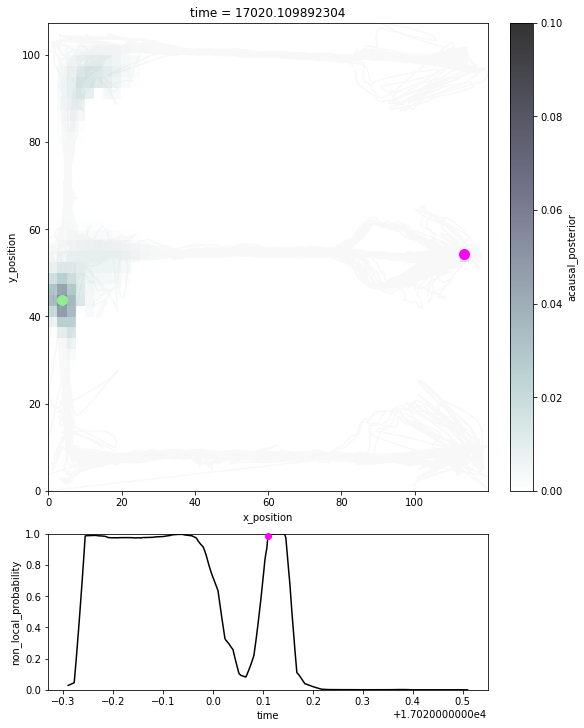

In [127]:
from src.analysis import maximum_a_posteriori_estimate


time_slice = slice(325_000, 350_000)

time_ind = 326_010

fig, axes = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]})
axes[0].plot(data['position_info'].nose_x,
             data['position_info'].nose_y,
             color='lightgrey',
             alpha=0.7,
             zorder=-1
           )
(detector_results_2D
 .isel(time=time_ind)
 .acausal_posterior
 .sum('state')
 .plot(x='x_position', y='y_position',
       robust=True, ax=axes[0],
       vmin=0.0, vmax=0.1, alpha=0.8, cmap='bone_r'))

map_estimate = maximum_a_posteriori_estimate(detector_results_2D.isel(time=time_ind).acausal_posterior.sum('state'))
axes[0].scatter(map_estimate[0], map_estimate[1], color='lightgreen', s=100, zorder=5)

axes[0].scatter(data['position_info'].iloc[time_ind].nose_x,
                data['position_info'].iloc[time_ind].nose_y,
                color='magenta',
                zorder=6,
                s=100
           )

(detector_results_2D
 .isel(time=slice(time_ind - 200, time_ind + 201))
 .non_local_probability
 .plot(x='time', ax=axes[1], color='black'))
axes[1].scatter(detector_results_2D.isel(time=time_ind).time,
                detector_results_2D.isel(time=time_ind).non_local_probability,
                color='magenta', zorder=10, clip_on=False)
axes[1].set_ylim((0, 1))

In [189]:
from tqdm.auto import tqdm
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def make_movie(time_slice, results, detector, data, video_slowdown=8,
               movie_name='video_name.mp4', sampling_frequency=500):
    posterior = results.acausal_posterior.isel(time=time_slice).sum('state')
    non_local_prob = results.non_local_probability.isel(time=time_slice)
    position_info = data['position_info'].iloc[time_slice]
    
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)
    
    # Initialize
    fig, ax = plt.subplots(1, 1, figsize=(4.4, 4.4))
    ax.plot(data['position_info'].nose_x,
             data['position_info'].nose_y,
             color='lightgrey',
             alpha=0.7,
             zorder=-1
           )
    
    map_dot = ax.scatter([], [], s=150, zorder=50, color='lightgreen',
                              label='Decoded position')
    actual_position_dot = ax.scatter([], [], s=150, zorder=51, color='magenta',
                                          label='Actual position')
    mesh = plt.pcolormesh(detector.edges_[0],
                          detector.edges_[1],
                          posterior.isel(time=0).values.T,
                          vmin=0.0, vmax=0.1, alpha=0.8, cmap='bone_r')
    title = ax.set_title('')
    n_frames = posterior.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)
    
    def _update_plot(time_ind):
        progress_bar.update()
        map_estimate = maximum_a_posteriori_estimate(posterior.isel(time=time_ind))
        actual_position = position_info.iloc[time_ind][['nose_x', 'nose_y']].to_numpy()
        
        map_dot.set_offsets((map_estimate[0], map_estimate[1]))
        actual_position_dot.set_offsets((actual_position[0], actual_position[1]))
        
        p = posterior.isel(time=time_ind).values.T
        mesh.set_array(p.ravel())
        
        title.set_text(f'Pr(non_local) = {non_local_prob.isel(time=time_ind).values:.02f}')

        return (map_dot, actual_position_dot, mesh, title)
    
    # Output
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

In [ ]:
make_movie(slice(325_000, 350_000), detector_results_2D, replay_detector_2D, data, video_slowdown=16,
            movie_name='test_2D_2.mp4', sampling_frequency=500);

0it [00:00, ?it/s]

04-Nov-21 14:35:55 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
04-Nov-21 14:35:55 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 880x880 -pix_fmt rgba -r 31 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y test_2D_2.mp4


(<Figure size 316.8x316.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7fa737237970>)

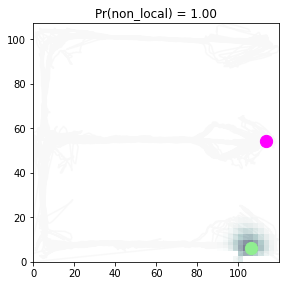

In [190]:
make_movie(slice(325_000, 327_100), detector_results_2D, replay_detector_2D, data, video_slowdown=16,
            movie_name='test_2D_2.mp4', sampling_frequency=500);

In [167]:
from ipywidgets import Video

Video.from_file('test_2D.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00B\\.mdat\x00\x00\x0…

In [197]:
from tqdm.auto import tqdm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def get_2D_map_estimate(posterior, decoder):
    map_position_ind = (
        posterior.where(decoder.is_track_interior_).argmax(
            "position", skipna=True).values
    )
    try:
        bin_center_2D_position = decoder.place_bin_center_2D_position_
    except AttributeError:
        bin_center_2D_position = np.asarray(
            decoder
            .place_bin_centers_nodes_df_
            .loc[:, ["x_position", "y_position"]])

        
    return bin_center_2D_position[map_position_ind]


def make_comparison_movie(time_slice, results_1D, results_2D, detector_1D, detector_2D, data, video_slowdown=8,
                          movie_name='video_name.mp4', sampling_frequency=500):
    posterior_1D = results_1D.acausal_posterior.isel(time=time_slice).sum('state')
    non_local_prob_1D = results_1D.non_local_probability.isel(time=time_slice)
    
    posterior_2D = results_2D.acausal_posterior.isel(time=time_slice).sum('state')
    non_local_prob_2D = results_2D.non_local_probability.isel(time=time_slice)

    position_info = data['position_info'].iloc[time_slice]
    
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)
    
    # Initialize
    fig, ax = plt.subplots(1, 1, figsize=(4.4, 4.4))
    ax.plot(data['position_info'].nose_x,
             data['position_info'].nose_y,
             color='lightgrey',
             alpha=0.7,
             zorder=-1
           )
    map_1D_dot = ax.scatter([], [], s=150, zorder=50, color='blue',
                            label='Decoded position')    
    map_2D_dot = ax.scatter([], [], s=150, zorder=50, color='lightgreen',
                            label='Decoded position')
    actual_position_dot = ax.scatter([], [], s=150, zorder=51, color='magenta',
                                          label='Actual position')
    mesh_2D = plt.pcolormesh(detector_2D.edges_[0],
                             detector_2D.edges_[1],
                             posterior_2D.isel(time=0).values.T,
                             vmin=0.0, vmax=0.1, alpha=0.8, cmap='bone_r')
    title = ax.set_title('')
    n_frames = posterior_2D.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)
    
    map_estimate_1D = get_2D_map_estimate(posterior_1D, detector_1D)
    map_estimate_2D = maximum_a_posteriori_estimate(posterior_2D)
    
    def _update_plot(time_ind):
        progress_bar.update()
        
        actual_position = position_info.iloc[time_ind][['nose_x', 'nose_y']].to_numpy()
        
        map_1D_dot.set_offsets((map_estimate_1D[time_ind, 0], map_estimate_1D[time_ind, 1]))
        map_2D_dot.set_offsets((map_estimate_2D[time_ind, 0], map_estimate_2D[time_ind, 1]))
        
        actual_position_dot.set_offsets((actual_position[0], actual_position[1]))
        
        p = posterior_2D.isel(time=time_ind).values.T
        mesh_2D.set_array(p.ravel())
        
        title.set_text(
            f'Pr(non_local_1D) = {non_local_prob_1D.isel(time=time_ind).values:.02f},\n'
            f'Pr(non_local_2D) = {non_local_prob_2D.isel(time=time_ind).values:.02f}')

        return (map_1D_dot, map_2D_dot, actual_position_dot, mesh_2D, title)
    
    # Output
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

0it [00:00, ?it/s]

04-Nov-21 15:41:25 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
04-Nov-21 15:41:25 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 880x880 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y compare1.mp4


(<Figure size 316.8x316.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7fa73d9d0e50>)

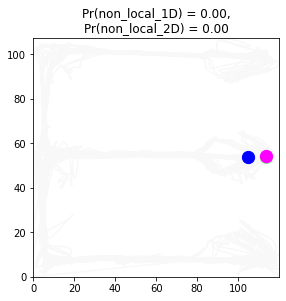

In [198]:
make_comparison_movie(slice(325_000, 327_100), detector_results, detector_results_2D, replay_detector, replay_detector_2D, data, video_slowdown=24,
                     movie_name='compare1.mp4')

In [200]:
from replay_trajectory_classification import SortedSpikesClassifier

continuous_transition_types = [['random_walk', 'uniform'],
                               ['uniform', 'uniform']]
classifier_parameters_2D = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'knot_spacing': 16.0,
    'spike_model_penalty': 0.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
}

classifier_2D = SortedSpikesClassifier(**classifier_parameters_2D)
classifier_2D

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                    ['uniform', 'uniform']],
                       discrete_transition_diag=0.968,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=16.0, movement_var=6.0, place_bin_size=2.5,
                       position_range=None, replay_speed=1,
                       spike_model_penalty=0.5)

In [202]:
classifier_2D.fit(
    position=data['position_info'].loc[:, ['nose_x', 'nose_y']],
    spikes=data['spikes'],
    is_training=data['position_info'].nose_vel > 4,
)

04-Nov-21 16:01:51 Fitting initial conditions...
04-Nov-21 16:01:51 Fitting state transition...
04-Nov-21 16:01:52 Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                    ['uniform', 'uniform']],
                       discrete_transition_diag=0.968,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=16.0, movement_var=6.0, place_bin_size=2.5,
                       position_range=None, replay_speed=1,
                       spike_model_penalty=0.5)

In [205]:
classifier_results_2D = classifier_2D.predict(
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    is_compute_acausal=True,
    state_names=['Continuous', 'Fragmented']
)

04-Nov-21 16:06:35 Estimating likelihood...
04-Nov-21 16:23:21 Estimating causal posterior...
05-Nov-21 02:35:15 Estimating acausal posterior...


In [206]:
# bar graph for multiunit and ripple power?

In [207]:
def make_comparison_movie2(time_slice, results_1D, results_2D, classifier_results_2D, detector_1D, detector_2D, data, video_slowdown=8,
                          movie_name='video_name.mp4', sampling_frequency=500):
    posterior_1D = results_1D.acausal_posterior.isel(time=time_slice).sum('state')
    non_local_prob_1D = results_1D.non_local_probability.isel(time=time_slice)
    
    posterior_2D = results_2D.acausal_posterior.isel(time=time_slice).sum('state')
    non_local_prob_2D = results_2D.non_local_probability.isel(time=time_slice)
    
    posterior_classifier_2D = classifier_results_2D.acausal_posterior.isel(time=time_slice).sum('state')

    position_info = data['position_info'].iloc[time_slice]
    
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)
    
    # Initialize
    fig, ax = plt.subplots(1, 1, figsize=(4.4, 4.4))
    ax.plot(data['position_info'].nose_x,
             data['position_info'].nose_y,
             color='lightgrey',
             alpha=0.7,
             zorder=-1
           )
    map_1D_dot = ax.scatter([], [], s=150, zorder=50, color='blue',
                            label='1D Decoded position')    
    map_2D_dot = ax.scatter([], [], s=150, zorder=50, color='lightgreen',
                            label='1D Decoded position')
    map_classifier_2D_dot = ax.scatter([], [], s=150, zorder=50, color='orange',
                                      label='Classifier position')
    
    actual_position_dot = ax.scatter([], [], s=150, zorder=51, color='magenta',
                                          label='Actual position')
    mesh_2D = plt.pcolormesh(detector_2D.edges_[0],
                             detector_2D.edges_[1],
                             posterior_2D.isel(time=0).values.T,
                             vmin=0.0, vmax=0.1, alpha=0.8, cmap='bone_r')
    title = ax.set_title('')
    n_frames = posterior_2D.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)
    
    map_estimate_1D = get_2D_map_estimate(posterior_1D, detector_1D)
    map_estimate_2D = maximum_a_posteriori_estimate(posterior_2D)
    map_estimate_classifier_2D = maximum_a_posteriori_estimate(posterior_classifier_2D)
    
    def _update_plot(time_ind):
        progress_bar.update()
        
        actual_position = position_info.iloc[time_ind][['nose_x', 'nose_y']].to_numpy()
        
        map_1D_dot.set_offsets((map_estimate_1D[time_ind, 0], map_estimate_1D[time_ind, 1]))
        map_2D_dot.set_offsets((map_estimate_2D[time_ind, 0], map_estimate_2D[time_ind, 1]))
        map_classifier_2D_dot.set_offsets((map_estimate_classifier_2D[time_ind, 0],
                                           map_estimate_classifier_2D[time_ind, 1]))
        
        actual_position_dot.set_offsets((actual_position[0], actual_position[1]))
        
        p = posterior_2D.isel(time=time_ind).values.T
        mesh_2D.set_array(p.ravel())
        
        title.set_text(
            f'Pr(non_local_1D) = {non_local_prob_1D.isel(time=time_ind).values:.02f},\n'
            f'Pr(non_local_2D) = {non_local_prob_2D.isel(time=time_ind).values:.02f}')

        return (map_1D_dot, map_2D_dot, map_classifier_2D_dot, actual_position_dot, mesh_2D, title)
    
    # Output
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie


0it [00:00, ?it/s]

05-Nov-21 14:15:57 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
05-Nov-21 14:15:57 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 880x880 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y compare2.mp4


(<Figure size 316.8x316.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7fa736df1a60>)

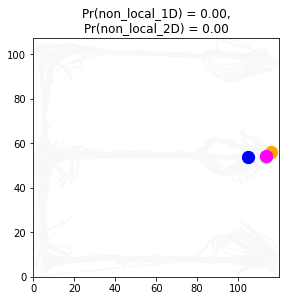

In [208]:
make_comparison_movie2(slice(325_000, 327_100), detector_results, detector_results_2D, classifier_results_2D, replay_detector, replay_detector_2D, data, video_slowdown=24,
                     movie_name='compare2.mp4')

0it [00:00, ?it/s]

05-Nov-21 14:49:40 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
05-Nov-21 14:49:40 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 880x880 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y compare2b.mp4


(<Figure size 316.8x316.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7fa737e5edc0>)

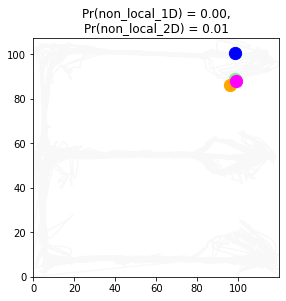

In [209]:
make_comparison_movie2(slice(327_000, 335_000), detector_results, detector_results_2D, classifier_results_2D, replay_detector, replay_detector_2D, data, video_slowdown=24,
                     movie_name='compare2b.mp4')

In [ ]:
make_comparison_movie2(slice(325_000, 350_000), detector_results, detector_results_2D, classifier_results_2D, replay_detector, replay_detector_2D, data, video_slowdown=24,
                     movie_name='compare2b.mp4')